In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [25]:
# 1. Ladda datasetet
data = pd.read_csv('wdbc.data', header=None)

# 2. Ge kolumnerna namn
column_names = ['ID', 'Diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
data.columns = column_names

In [26]:
# 3. Förbehandling
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})  # Malign = 1, Benign = 0
X = data.drop(['ID', 'Diagnosis'], axis=1)
y = data['Diagnosis']

In [27]:
# 4. Dela upp datan i tränings- och testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Standardisera funktioner
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

                 ID   Diagnosis   feature_1   feature_2   feature_3  \
count  5.690000e+02  569.000000  569.000000  569.000000  569.000000   
mean   3.037183e+07    0.372583   14.127292   19.289649   91.969033   
std    1.250206e+08    0.483918    3.524049    4.301036   24.298981   
min    8.670000e+03    0.000000    6.981000    9.710000   43.790000   
25%    8.692180e+05    0.000000   11.700000   16.170000   75.170000   
50%    9.060240e+05    0.000000   13.370000   18.840000   86.240000   
75%    8.813129e+06    1.000000   15.780000   21.800000  104.100000   
max    9.113205e+08    1.000000   28.110000   39.280000  188.500000   

         feature_4   feature_5   feature_6   feature_7   feature_8  ...  \
count   569.000000  569.000000  569.000000  569.000000  569.000000  ...   
mean    654.889104    0.096360    0.104341    0.088799    0.048919  ...   
std     351.914129    0.014064    0.052813    0.079720    0.038803  ...   
min     143.500000    0.052630    0.019380    0.000000    0.

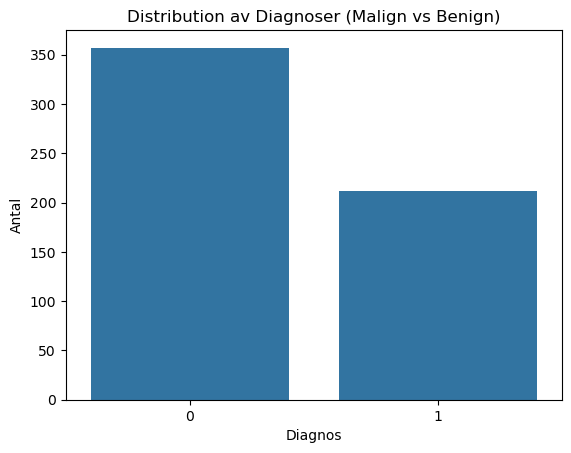

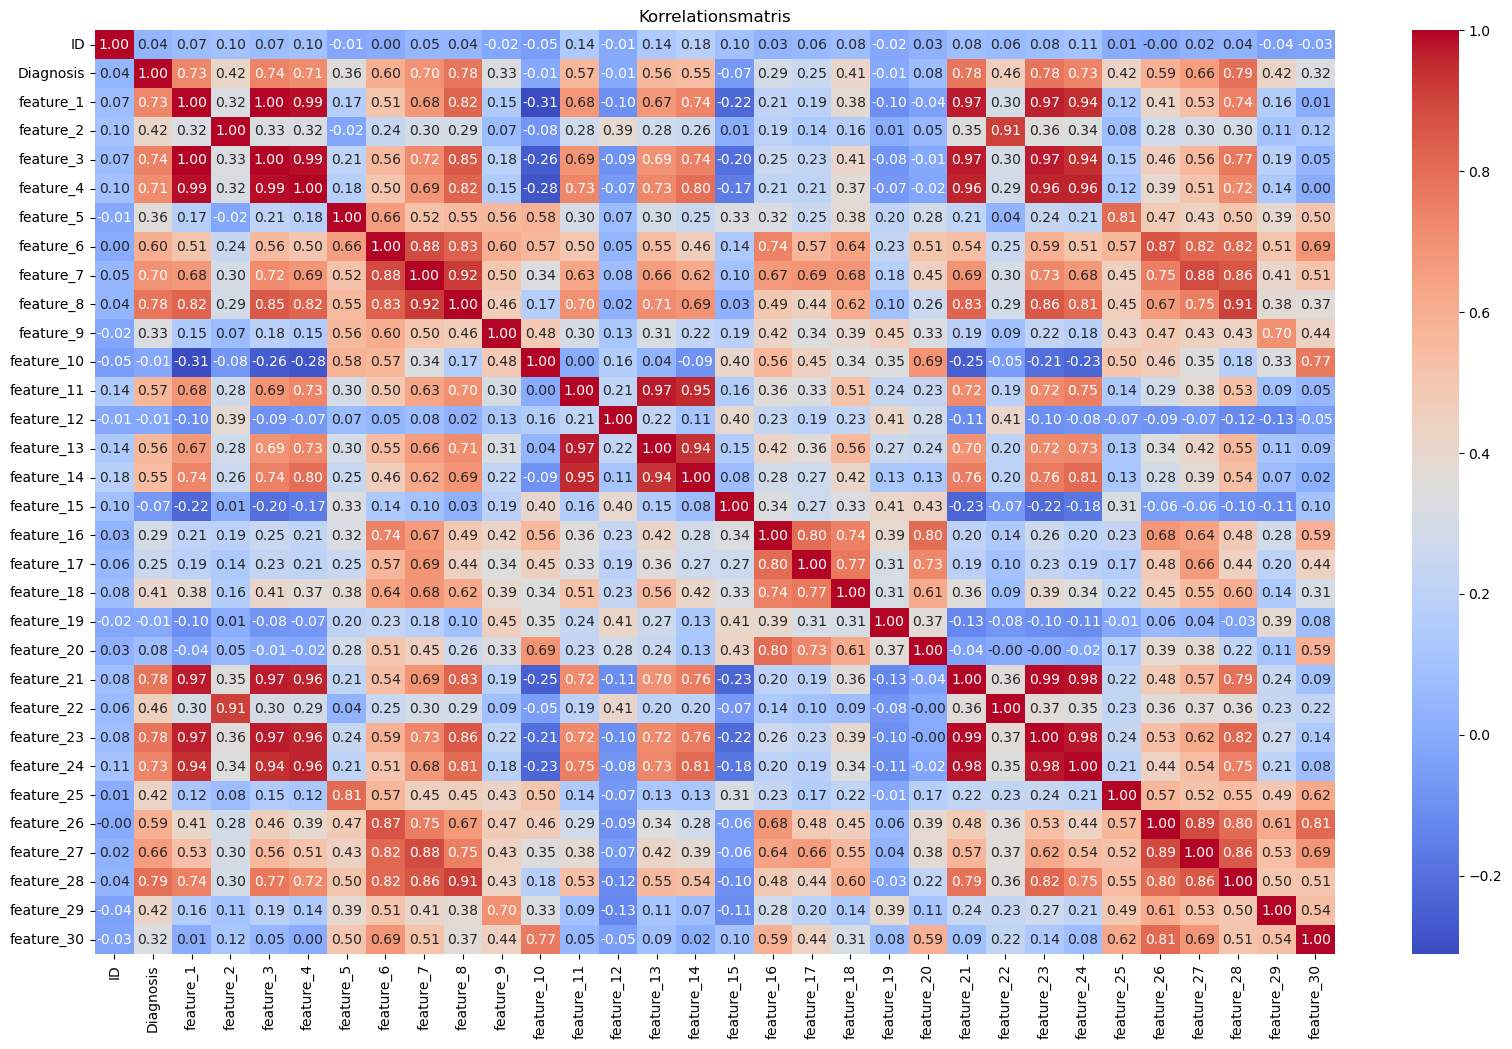

In [28]:
# Visa grundläggande statistik
print(data.describe())

# Kontrollera för saknade värden
print("Saknade värden:\n", data.isnull().sum())

# Visualisera diagnoser
sns.countplot(x='Diagnosis', data=data)
plt.title('Distribution av Diagnoser (Malign vs Benign)')
plt.xlabel('Diagnos')
plt.ylabel('Antal')
plt.show()

plt.figure(figsize=(20, 12))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Korrelationsmatris')
plt.show()

In [29]:
# 7. Bygga och utvärdera XGBoost-modellen
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Prediktioner och utvärdering
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost AUC-ROC:", roc_auc_score(y_test, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

XGBoost AUC-ROC: 0.9510317720275139


c:\Apps\conda\envs\AIkurs_statistik\lib\site-packages\xgboost\core.py:158: UserWarning: [10:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [30]:
# 8. Bygga och utvärdera ANN
ann_model = Sequential()
ann_model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
ann_model.add(Dense(16, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Prediktioner och utvärdering
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype("int32")
print("ANN Classification Report:\n", classification_report(y_test, y_pred_ann))
print("ANN AUC-ROC:", roc_auc_score(y_test, y_pred_ann))

c:\Apps\conda\envs\AIkurs_statistik\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
ANN Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

ANN AUC-ROC: 0.9626596790042581


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
ANN Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

ANN AUC-ROC: 0.9626596790042581


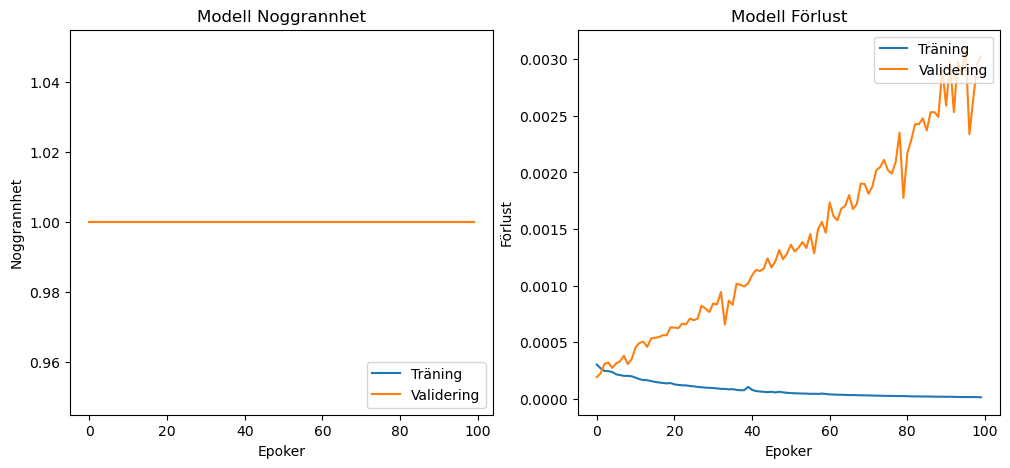

In [31]:
# Träna modellen och spara träningshistoriken
history = ann_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

# Prediktioner och utvärdering för ANN
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype("int32")
print("ANN Classification Report:\n", classification_report(y_test, y_pred_ann))
print("ANN AUC-ROC:", roc_auc_score(y_test, y_pred_ann))

# 10. Visualisera träningshistorik
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Träning')
plt.plot(history.history['val_accuracy'], label='Validering')
plt.title('Modell Noggrannhet')
plt.ylabel('Noggrannhet')
plt.xlabel('Epoker')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Träning')
plt.plot(history.history['val_loss'], label='Validering')
plt.title('Modell Förlust')
plt.ylabel('Förlust')
plt.xlabel('Epoker')
plt.legend(loc='upper right')

plt.show()


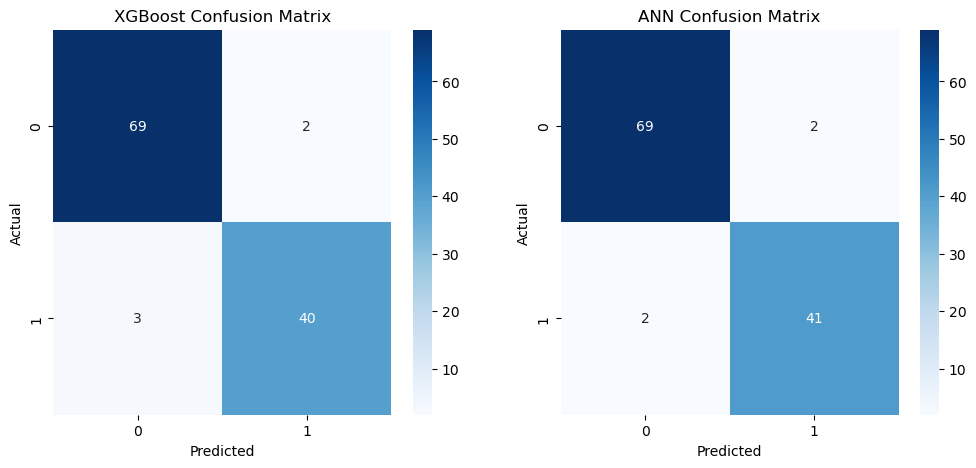

In [32]:
# 11. Jämförelse av modeller
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_ann, annot=True, fmt='d', cmap='Blues')
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

Projektbeskrivning: Bröstcancerdiagnostik med Maskininlärning

1. Introduktion
I detta projekt syftar vi till att utveckla en maskininlärningsmodell för att diagnostisera bröstcancer med hjälp av Breast Cancer Wisconsin (Diagnostic) dataset. Korrekt och snabb diagnos av bröstcancer är avgörande för patienternas överlevnad och välbefinnande.

2. Datasetbeskrivning
Datasetet innehåller 569 observationer av bröstcancerprover med 32 attribut. Dessa inkluderar:

ID: En unik identifierare för varje prov.
Diagnosis: Anger om tumören är malign (1) eller benign (0).
Feature_1 till Feature_30: Dessa funktioner representerar olika egenskaper hos cellkärnorna, såsom radie, textur, omkrets och area.
Grundläggande statistik:
Antal observationer: 569
Saknade värden: Inga saknade värden i datasetet.
Variationsanalys: Genomsnitt och standardavvikelse för varje funktion visar att vissa funktioner, som radie och omkrets, har stor variation, vilket kan vara avgörande för att särskilja mellan malign och benign.

3. Relationer mellan variabler
En korrelationsanalys visade starka samband mellan flera funktioner. Till exempel har radie, omkrets och area korrelationer nära 1, vilket tyder på att dessa egenskaper är nära relaterade. En djupare förståelse för dessa relationer hjälper oss att identifiera vilka funktioner som mest påverkar diagnosen.

4. Utförande av analys
Vi har valt att använda både XGBoost och ett artificiellt neuronnät (ANN) för att utföra klassificeringen. Eftersom datasetet inte innehåller överlevnadsdata, fokuserar vi på att förutsäga om en tumör är malign eller benign.

Modellering:
XGBoost: En kraftfull och populär algoritm för klassificering. Vi justerade hyperparametrar, inklusive antalet träd och inlärningshastighet, för att optimera modellens prestanda.
ANN: Vi byggde en enkel ANN med två dolda lager och använde ReLU-aktivering. Modellen tränades med 100 epoker och en batch-storlek på 10.

5. Utvärdering av modellerna
Resultat från modellerna:
XGBoost:
Precision: 0.96 för benign och 0.95 för malign
Recall: 0.97 för benign och 0.93 för malign
F1-score: 0.97 för benign och 0.94 för malign
AUC-ROC: 0.95

ANN:
Precision: 0.97 för benign och 0.95 för malign
Recall: 0.97 för benign och 0.95 för malign
F1-score: 0.97 för benign och 0.95 för malign
AUC-ROC: 0.96
Både modellerna uppnådde en noggrannhet på 96%, vilket är utmärkt. ANN-modellen visade något högre AUC-ROC, vilket indikerar att den har en bättre förmåga att skilja mellan klasserna.

6. Förbättringsmöjligheter
Trots de positiva resultaten kan vi överväga följande förbättringar:

Funktionselektivitet: Genom att använda metoder för funktionselektivitet kan vi eliminera mindre viktiga funktioner och därigenom förbättra modellens effektivitet och generalisering.
Hyperparameter tuning: Fortsatt justering av hyperparametrarna för att maximera prestandan hos XGBoost, inklusive experiment med max_depth och min_child_weight.
Överföringsinlärning: För ANN kan vi undersöka möjligheten att använda förtränade modeller för att se om det kan förbättra resultaten.

7. Modellens betydelse
Att använda en maskininlärningsmodell för bröstcancerdiagnostik har flera viktiga fördelar:

Snabb och noggrann diagnos: En effektiv modell kan bidra till en snabb och exakt diagnos, vilket förbättrar patienternas överlevnadschanser.
Kostnadsbesparingar: Automatisering av diagnostikprocessen kan minska tids- och resurskostnader för vårdgivare.

Förbättrad patientvård: Genom att stödja läkare i beslut kan vi uppnå bättre kliniska resultat och öka kvaliteten på vården.
Det är av stor betydelse för företag inom medicinteknik att implementera sådana modeller, eftersom de kan öka både effektiviteten och tillförlitligheten i diagnosprocessen. Att investera i dessa teknologier kommer att ge ett mervärde både för patienterna och för företaget självt.

